# WebDataset

WebDataset is a standard for representing dataset for training deep learning and machine learning models, with other implementation in Python [github.com/tmbdev/webdataset](http://github.com/tmbdev/webdataset) and Go [github.com/tmbdev/tarp](http://github.com/tmbdev/tarp).

WebDataset solves the small files problem and enables massively parallel and high bandwidth I/O for training on both small and very large (petascale) datasets.

This is a first cut at a Julia implementation, taking advantage of Julia's multithreading.

Status/Todo:

- add Documenter.jl code comments
- write full Flux.jl demonstration project

# Datasets

WebDatasets consists of a collection of tar files ("shards"). Each tar file is read sequentially, and multiple shards may be read in parallel.

Within each tar file, files with a common basename but different extensions are grouped together into training samples. The "basename" is defined here as the directory name plus the file name up to the first "." in the file name.

Training samples for learning stereo models might contain a sequence of samples of the form:

```Shell
$ tar xvf stereo-dataset-000179.tar
098953.left.jpg
098953.right.jpg
098953.depth.png16
194432.left.jpg
194432.right.jpg
194432.depth.png16
...
$ 
```

# Creating Datasets

Since WebDatasets are just tar files, you can use many different tools to create and process them. All you need to make sure is that files that belong to the same training sample are adjacent to each other and have the same basename.

If your data is already laid out like that on the file system, you can use `tar --sorted`:

```Shell
$ tar --sorted dataset > dataset.tar
```

You can also use the `tarp create` command (at [github.com/tmbdev/tarp](http://github.com/tmbdev/tarp)) with a recipe file.

And you can use Python or Julia scripts to write such files directly. For example, [makeshards.py](https://github.com/tmbdev/webdataset-lightning/blob/main/makeshards.py) uses some existing PyTorch code to quickly convert Imagenet data into sharded tar files.


# Julia Dataloaders

Training samples are represented as `Dict{String,Any}` instances in the library.

Dataset loading takes place in multiple stages:

```
tar file reading -> grouping into samples 
    -> decoding of samples -> augmentation of samples -> whole sample mapping 
    -> batching -> collating
```

The `dataloader` function will set up such a loading pipeline and run it in parallel in multiple threads. The entire process is described by a dataset descriptor:

```Julia
@with_kw mutable struct DatasetDescriptor
    # list of shards
    sources::Array{Union{String,Cmd}} = []
    # size of the inline shuffle buffer
    shuffle::Int = 1000
    # batchsize (0 for no batching)
    batchsize::Int = 16
    # decoding functions
    decoding::Array{Pair{Union{String,Regex,Renamer},Function}} = [""=>x->x]
    # augmentation functions
    augmenting::Array{Pair{Union{String,Regex,Renamer},Function}} = [""=>x->x]
    # a general mapping function running after augmentation
    mapping::Function = x->x
    # collation functions running after batching
    collating::Array{Pair{Union{String,Regex,Renamer},Function}} = [""=>x->x]
    # channel size for output channel
    csize::Int = 100
    # number of concurrent tasks/shards for loading
    ntasks::Int = 4
    # more verbose output
    verbose::Bool = false
    # even more verbose output
    debug::Bool = false
end
```

Here, `decoding`, `augmenting`, and `collating` are lists of mapping rules that are searched sequentially for a matching rule.  The default decoders are very simple:


```Julia
default_decoders = [
    ".cls" => clsdecode,
    Rename(r".(jpg|jpg|png|p?m)$", ".img") => imdecode,
    ".json" => jsondecode,
]
```

This says that every file ending in `.cls` should be decoded with the `clsdecode` function and every file ending in `.json` should be decoded using `jsondecode`. Files matching the regular expression should have their matching portion renamed to `.img` and should be decoded using the `imdecode` function.

Decoder functions should take `UInt8` arrays containing the binary file content and decode into whatever data structure is desired. Augmentation functions take the decoded outputs as inputs and produce new outputs. Collating functions take a list of decoded items (e.g., all files ending in `.img`) and can, for example, stack them together into arrays.

# Simple Example

In this example, we start by defining a simple `DatasetDescriptor`; we're using the default decoders.

In [1]:
using WebDataset
using Images
using Flux: batch

For decoding, we just use the default decoders. This will map `something.cls` files to integers, and common image files to Julia images. In addition, it renames any image extension to the common `.img` extension to make it easier to reference later.

In [2]:
default_decoders

3-element Vector{Pair{Any, Function}}:
                                 ".cls" => WebDataset.clsdecode
 Rename(r".(jpg|jpg|png|p?m)$", ".img") => WebDataset.imdecode
                                ".json" => WebDataset.jsondecode

After decoding, we want to augment inputs. Augmentations are just mappings for individual components of the training sample. In this case, we are only augmenting the images, i.e., samples ending in `.img`.

In some cases, you may need to augment multiple images jointly (e.g., when distorting both an input image and its segmentation with the same parameters; in that case, use the `mapping` option, which receives whole training samples.

In [3]:
function image_augmentation(image)
    result = channelview(imresize(RGB.(image), (256, 256)))
    # add distortions, cropping, etc. here as needed
    return result
end

augmenting = [
    # call whatever augmentation you like for individual images
    ".img" => image_augmentation,
    # this line ensures that any other sample components are carried along unchanged
    "" => x->x
]

2-element Vector{Pair{String, Function}}:
 ".img" => image_augmentation
     "" => var"#1#2"()

The library distinguishes _batching_ and _collating_. Batching creates batches out of collections of training samples. For example, for batchsize 32, the ".img" components of each sample are collecting into an array containing 32 separate images. Collating transforms that array of images into a single array representing the entire batch. Here, we're using the `Flux.batch` function for that.

In [4]:
collating = [
    # .cls is turned  into an Array{Int}
    ".cls" => data->Array{Int}(data),
    # RGB images are batched using Flux.batch
    ".img" => l->batch(l),
]

2-element Vector{Pair{String, Function}}:
 ".cls" => var"#3#5"()
 ".img" => var"#4#6"()

Datasets are represented as tar files. Big tar files are broken up into numbered shards. To reference those shards compactly, we usually use brace notation as used by the shell. Brace expansion is implemented by the `braceexpand` function. Here, we're selecting just four shards for the demonstration.

In [5]:
shards = braceexpand("pipe:curl -L -s http://storage.googleapis.com/nvdata-coco/coco-train2014-seg-{000000..000003}.tar")
shards = braceexpand("/work-2020/shards/imagenet/imagenet-train-{000000..000146}.tar")[1:4]

4-element Vector{Any}:
 "/work-2020/shards/imagenet/imagenet-train-000000.tar"
 "/work-2020/shards/imagenet/imagenet-train-000001.tar"
 "/work-2020/shards/imagenet/imagenet-train-000002.tar"
 "/work-2020/shards/imagenet/imagenet-train-000003.tar"

We collect all the information describing a dataset into a `DatasetDescriptor`. This is passed to data loaders to actually preprocess and load the data.

In [6]:
desc = DatasetDescriptor(
    sources=shards,
    shuffle=1000,
    batchsize=32,
    decoding=default_decoders,
    augmenting=augmenting,
    collating=collating,
)

DatasetDescriptor
  sources: Array{Union{Cmd, String}}((4,))
  shuffle: Int64 1000
  batchsize: Int64 32
  decoding: Array{Pair{Union{Regex, String, WebDataset.Renamer}, Function}}((3,))
  augmenting: Array{Pair{Union{Regex, String, WebDataset.Renamer}, Function}}((2,))
  mapping: #23 (function of type WebDataset.var"#23#33")
  collating: Array{Pair{Union{Regex, String, WebDataset.Renamer}, Function}}((2,))
  csize: Int64 100
  ntasks: Int64 4
  verbose: Bool false
  debug: Bool false


Multithreaded code does not give particularly nice error messages, so it's useful to test a data loader with a nonthreaded `debugloader` first. This will just load a few samples, and any errors will show up as regular stack traces.

In [7]:
if true
    ch = debugloader(desc, desc.sources)
    sample = take!(ch)
    @show size(sample[".img"])
end;

size(sample[".img"]) = (3, 256, 256, 32)


For actual loading, we use a multithreaded loader.

In [8]:
# use four threads
desc.ntasks = 4

# we keep track of the number of batche and number of samples
(count, total) = (0, 0)

# also, let's keep the last sample
global last_sample

# dataloader actually returns a Channel of samples
@time for sample in dataloader(desc)
    last_sample = sample
    count += 1
    total += length(sample["__key__"])
    if count % 100 == 1; @show count, total; end
end

# let's look at the final tally
(count, total)

(count, total) = (1, 32)
(count, total) = (101, 3232)
(count, total) = (201, 6432)
(count, total) = (301, 9632)
(count, total) = (401, 12832)
(count, total) = (501, 16032)
(count, total) = (601, 19232)
(count, total) = (701, 22432)
(count, total) = (801, 25632)
(count, total) = (901, 28832)
(count, total) = (1001, 32032)
 77.417172 seconds (14.02 M allocations: 126.523 GiB, 2.14% gc time, 0.34% compilation time)


(1052, 33607)

We are getting a nicely batched sample with additional information about sample keys.

In [9]:
last_sample

Dict{String, Any} with 3 entries:
  "__key__" => ["0890723", "0694866", "1231035", "0733904", "0257063", "0039674…
  ".img"    => N0f8[0.792 0.792 … 0.043 0.051; 0.184 0.184 … 0.035 0.039; 0.067…
  ".cls"    => [694, 541, 961, 571, 201, 30, 305, 512, 769, 920, 329, 36, 916, …

Four Julia threads give us about 450 decoded images per second. The code scales completely linearly, though Julia multithreading seems to have some overhead when running many threads in parallel.

In [10]:
33607/73.4

457.86103542234326

Any exceptions in the multithreaded code are available here.

In [11]:
WebDataset.num_exceptions, WebDataset.last_exception

(Base.Threads.Atomic{Int64}(0), nothing)

# Under the Hood

The `dataloader` function gives you one particular way of multithreaded data loading and augmentation. It is built from a number of simple iterators that you can reuse and recombine in other ways if you like. You can also use distributed computing for distributed loading and augmentation. The core functionality is expressed by this composition of iterators:

```Julia
# open either a file or a pipe: source
stream = generic_open(source)

# iterate over samples in the .tar archive
raw = sampleiterator(stream)

# shuffle samples with a shuffle buffer
shuffled = sampleshuffle(raw, desc.shuffle)

# decode the samples based on decoding rules
decoded = sampletransforms(shuffled, desc.decoding)

# augment the samples based on agumentation rules
augmented = sampletransforms(decoded, desc.augmenting)

# batch the samples to the given batch size
batched = samplebatching(augmented, desc.batchsize)

# collate individual fields based on collating rules
collated = sampletransforms(batched, desc.collating)
```


Example: iterating over raw, undecoded samples.

In [20]:
for sample in sampleiterator(open("test.tar"))
    display(sample)
    break
end

Dict{String, Any} with 3 entries:
  "__key__" => "1170061"
  ".jpg"    => UInt8[0xff, 0xd8, 0xff, 0xe0, 0x00, 0x10, 0x4a, 0x46, 0x49, 0x46…
  ".cls"    => UInt8[0x39, 0x31, 0x33]

Example: iterating over decoded samples

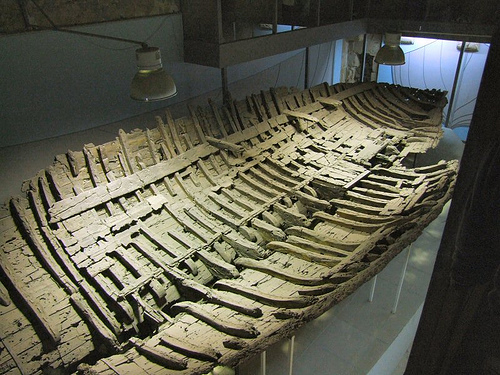

In [22]:
for sample in sampleiterator(open("test.tar")) |> it->sampletransforms(it, default_decoders)
    display(sample[".img"])
    break
end